# Almgren-Chriss Framework – Power-Law Execution Costs

## Objective
Implement the **generalized Almgren-Chriss model** with empirically-calibrated power-law execution costs:
- **Power-law execution costs**: $ L(\rho) = \eta |\rho|^{1+\phi} + \psi |\rho| $
- **Empirical calibration**: Based on literature (Almgren et al. 2005, Kyle & Obizhaeva 2016, Bacry et al. 2015)
- **Numerical solution**: Using Hamiltonian characterization from Guéant

This notebook serves as:
- **Realistic implementation** of market impact with power-law costs
- **Empirically grounded** model based on academic literature
- **Comparison** with quadratic baseline

---

## Model (Guéant, Chapter 3 - Generalized Almgren-Chriss)

### Price Dynamics (with Linear Permanent Impact)
$$
dS_t = \sigma \, dW_t + k \, v_t \, dt
$$
> $ v_t = \dot{q}_t $: trading speed (shares/day)  
> $ k $: permanent impact coefficient (must be linear to avoid arbitrage - Huberman & Stanzl 2004)  
> $ \sigma $: annualized volatility

### Execution Costs (Temporary / Instantaneous Impact)
$$
L(\rho) = \eta |\rho|^{1+\phi} + \psi |\rho|, \quad \rho_t = \frac{|v_t|}{V}
$$

**Empirical values from literature:**
- **φ (power-law exponent)**: Typically 0.4 - 0.7
  - Almgren et al. (2005): ~0.6
  - Kyle & Obizhaeva (2016): ~0.6  
  - Square root law: φ = 0.5 (most popular)
  - Engle et al. (2012): 0.37-0.43
  - Frazzini et al. (2018): ~0.35
- **ψ (proportional costs)**: Bid-ask spread + fees

### Cash Process (for Liquidation, $ q_0 > 0 $)
$$
dX_t = - S_t \, v_t \, dt - V \cdot L\left(\frac{v_t}{V}\right) \, dt
$$

---

### Optimization Objective
Minimize the **risk-adjusted expected implementation shortfall**:
$$
\min_{v_t} \quad \mathbb{E}\left[ X_T \right] + \frac{\lambda}{2} \operatorname{Var}\left[ X_T \right]
$$
> $ \lambda $: risk aversion parameter  
> $ X_T $: final cash after unwinding $ q_0 \to 0 $ over $ [0, T] $

---

### Hamiltonian Characterization (Guéant, Eq. 3.10)
$$
\begin{cases}
p'(t) = \gamma \sigma^2 q^*(t) \\
q^{*'}(t) = V_t H'(p(t)) \\
q^*(0) = q_0 \\
q^*(T) = 0
\end{cases}
$$

where $ H $ is the Legendre-Fenchel transform of $ L $:
$$
H(p) = \sup_{\rho} \left\{ \rho p - L(\rho) \right\}
$$

**For power-law costs** $ L(\rho) = \eta |\rho|^{1+\phi} + \psi |\rho| $ (Guéant, Eq. 3.11):
$$
H(p) = \begin{cases}
0 & \text{if } |p| \leq \psi \\
\frac{\phi}{\eta(1+\phi)} \left(\frac{|p|-\psi}{\eta}\right)^{1 + 1/\phi} & \text{otherwise}
\end{cases}
$$

$$
H'(p) = \begin{cases}
0 & \text{if } |p| \leq \psi \\
\text{sign}(p) \left(\frac{|p|-\psi}{\eta}\right)^{1/\phi} & \text{otherwise}
\end{cases}
$$

> **No closed form** for $ \phi \neq 1 $, requires numerical solution

---

## Inputs (for Practical Illustration)
- Market data: `data/processed/market_data_intraday.parquet`
  - Extract $ \sigma $ (annualized volatility)
  - Extract $ V $ (average daily volume)
- Execution scenario: $ q_0 = 200,000 $ shares, $ T = 1 $ day

## Outputs
- Optimal trading curve $ q^*(t) $, $ v^*(t) $ via numerical solution
- Comparison with **quadratic model** (baseline)
- Cost breakdown: execution, permanent impact, timing risk
- Implementation shortfall in € and bps

In [1]:
# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_bvp
from scipy.optimize import brentq
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# Configuration graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

print("✅ Imports réussis")

✅ Imports réussis


In [2]:
# Chargement des données de marché

df_market = pd.read_parquet('data/processed/market_data_intraday.parquet')

# Sélectionner un ticker
TICKER = 'AAPL'
data_ticker = df_market[df_market['ticker'] == TICKER]

print(f"📊 Données chargées pour {TICKER}")
print(f"   Période : {data_ticker.index.min()} → {data_ticker.index.max()}")
print(f"   Nombre de lignes : {len(data_ticker):,}")

📊 Données chargées pour AAPL
   Période : 2025-01-02 14:30:00+00:00 → 2025-06-27 19:59:00+00:00
   Nombre de lignes : 47,190


In [3]:
# PARAMETERS FROM MARKET DATA
df_params = pd.read_parquet('data/processed/market_parameters.parquet')
params_data = df_params[df_params['ticker'] == TICKER].iloc[0]

sigma = params_data['vol_annual']  # Volatility σ
V = params_data['volume_per_day']  # Constant market volume

print(f"✅ Parameters loaded for {TICKER}:")
print(f"   σ = {sigma:.4f}")
print(f"   V = {V:,.0f} shares/day")

# LITERATURE-BASED PARAMETERS FOR POWER-LAW MODEL
print("\n🔬 Empirical parameters from literature:")

# Permanent impact (must be linear - Huberman & Stanzl 2004)
k = 0.0025  
print(f"   k (permanent impact)    = {k:.6f} [linear, no-arbitrage]")

# Power-law parameters
phi = 0.5  # Square root law (Almgren et al. 2005, Kyle & Obizhaeva 2016)
print(f"   φ (power exponent)      = {phi} [square root, Almgren+ 2005]")

eta = 0.10  # Execution cost coefficient
print(f"   η (cost coefficient)    = {eta}")

psi = 0.002  # Proportional costs (bid-ask + fees), in fraction of price
print(f"   ψ (proportional costs)  = {psi} = {psi*10000:.0f} bps [spread + fees]")

# RISK AVERSION
lambda_risk = 5e-6  
print(f"   λ (risk aversion)       = {lambda_risk:.6f}")

# EXECUTION SCENARIO (Unwinding q0 over T)
q0 = 200_000  # Initial position (shares; >0 for liquidation/selling)
T = 1.0       # Horizon (days)
S0 = data_ticker['close'].iloc[-1]  # Initial price (for shortfall calc)

print(f"\n🎯 Execution scenario (unwinding to q_T=0):")
print(f"   q₀ = {q0:,} shares")
print(f"   T  = {T} day (390 minutes)")
print(f"   S₀ = {S0:.2f}")
print(f"   Notional = {abs(q0)*S0:,.0f}")

print("\n" + "="*70 + "\n")

# SUMMARY
params = {
    'sigma': sigma,
    'V': V,
    'k': k,  # Permanent (renamed from b)
    'phi': phi,  # Power exponent
    'eta': eta,  # Temporary
    'psi': psi,  # Proportional
    'lambda_risk': lambda_risk,
    'q0': q0,
    'T': T,
    'S0': S0
}
print("\n📋 Résumé des paramètres :")
for key, val in params.items():
    if isinstance(val, float) and val < 0.01:
        print(f"   {key:12s} = {val:.6f}")
    elif isinstance(val, float):
        print(f"   {key:12s} = {val:,.4f}")
    else:
        print(f"   {key:12s} = {val:,}")

✅ Parameters loaded for AAPL:
   σ = 0.3992
   V = 10,782,696 shares/day

🔬 Empirical parameters from literature:
   k (permanent impact)    = 0.002500 [linear, no-arbitrage]
   φ (power exponent)      = 0.5 [square root, Almgren+ 2005]
   η (cost coefficient)    = 0.1
   ψ (proportional costs)  = 0.002 = 20 bps [spread + fees]
   λ (risk aversion)       = 0.000005

🎯 Execution scenario (unwinding to q_T=0):
   q₀ = 200,000 shares
   T  = 1.0 day (390 minutes)
   S₀ = 201.10
   Notional = 40,220,000



📋 Résumé des paramètres :
   sigma        = 0.3992
   V            = 10,782,696.0413
   k            = 0.002500
   phi          = 0.5000
   eta          = 0.1000
   psi          = 0.002000
   lambda_risk  = 0.000005
   q0           = 200,000
   T            = 1.0000
   S0           = 201.1000


## Classe AlmgrenChrissPowerLaw

Implémentation du modèle généralisé avec coûts en loi de puissance, basé sur la caractérisation Hamiltonienne de Guéant (Chapter 3).

In [4]:
class AlmgrenChrissPowerLaw:
    """
    Almgren-Chriss generalized model with power-law execution costs.
    
    Cost function: L(ρ) = η|ρ|^(1+φ) + ψ|ρ|
    where ρ = v/V is the participation rate.
    
    Reference: Guéant, "Financial Mathematics of Market Liquidity", Chapter 3
    Empirical calibration: Almgren et al. (2005), Kyle & Obizhaeva (2016)
    """
    
    def __init__(self, 
                 lambda_risk: float,  # Risk aversion λ
                 sigma: float,        # Volatility
                 k: float,            # Permanent impact
                 phi: float,          # Power exponent
                 eta: float,          # Execution cost coeff
                 psi: float,          # Proportional costs
                 V: float):           # Market volume
        
        self.lambda_risk = lambda_risk
        self.sigma = sigma
        self.k = k
        self.phi = phi
        self.eta = eta
        self.psi = psi
        self.V = V
    
    def L(self, rho):
        """
        Execution cost function: L(ρ) = η|ρ|^(1+φ) + ψ|ρ|
        """
        return self.eta * np.abs(rho)**(1 + self.phi) + self.psi * np.abs(rho)
    
    def H_prime(self, p):
        """
        Derivative of Legendre-Fenchel transform H'(p).
        
        From Guéant Eq. 3.11:
        H'(p) = { 0                           if |p| ≤ ψ
                { sign(p) * ((|p|-ψ)/η)^(1/φ)  otherwise
        
        Vectorized to handle both scalars and arrays (needed for solve_bvp).
        """
        # Ensure p is array for vectorized operations
        p_array = np.atleast_1d(p)
        abs_p = np.abs(p_array)
        sign_p = np.sign(p_array)
        
        # Initialize result (dead zone = 0)
        result = np.zeros_like(p_array, dtype=float)
        
        # Active zone: |p| > ψ
        mask = abs_p > self.psi
        if np.any(mask):
            result[mask] = sign_p[mask] * ((abs_p[mask] - self.psi) / self.eta)**(1.0 / self.phi)
        
        # Return scalar if input was scalar, otherwise array
        return result.item() if p_array.shape == (1,) else result
    
    def hamiltonian_system(self, t, y):
        """
        Hamiltonian system for optimal trajectory.
        
        y = [q, p] where q is position and p is dual variable.
        
        System (Guéant Eq. 3.10):
        q'(t) = V * H'(p(t))
        p'(t) = γσ² * q(t)
        """
        q, p = y
        
        # H_prime now handles arrays properly
        dq_dt = self.V * self.H_prime(p)
        dp_dt = self.lambda_risk * self.sigma**2 * q
        
        return np.vstack([dq_dt, dp_dt])
    
    def boundary_conditions(self, ya, yb, q0):
        """
        Boundary conditions: q(0) = q0, q(T) = 0
        """
        return np.array([ya[0] - q0, yb[0]])
    
    def optimal_trajectory(self, 
                           q0: float, 
                           T: float, 
                           N: int = 390) -> tuple:
        """
        Compute optimal trajectory via BVP solver.
        
        Returns: t, q_star, v_star
        """
        
        # Initial guess: linear trajectory
        t_guess = np.linspace(0, T, N)
        q_guess = q0 * (1 - t_guess / T)
        
        # Guess for dual variable p: should start non-zero and decay
        p_guess = self.psi * 2 * np.ones_like(t_guess)  # Start above threshold
        
        y_guess = np.vstack([q_guess, p_guess])
        
        # Solve BVP
        sol = solve_bvp(
            lambda t, y: self.hamiltonian_system(t, y),
            lambda ya, yb: self.boundary_conditions(ya, yb, q0),
            t_guess,
            y_guess,
            tol=1e-8,
            max_nodes=5000
        )
        
        if not sol.success:
            raise RuntimeError(f"BVP solver failed: {sol.message}")
        
        # Evaluate on fine grid
        t = np.linspace(0, T, N+1)
        y = sol.sol(t)
        q_star = y[0]
        p_star = y[1]
        
        # Compute velocity v = dq/dt = V * H'(p)
        v_star = self.V * self.H_prime(p_star)
        
        return t, q_star, v_star
    
    def compute_costs(self, 
                      q0: float, 
                      T: float, 
                      strategy: str = 'optimal') -> dict:
        """
        Compute costs for given strategy.
        
        - Execution cost: ∫ V·L(v/V) dt
        - Permanent impact: k·|q0| / 2
        - Price risk: (λ/2)·σ²·∫ q² dt
        """
        
        if strategy == 'optimal':
            t, q, v = self.optimal_trajectory(q0, T)
        elif strategy in ['twap', 'vwap']:
            t = np.linspace(0, T, 391)
            q = q0 * (1 - t / T) if q0 > 0 else q0 * (t / T - 1)
            v = -(q0 / T) * np.ones_like(t) if q0 > 0 else (abs(q0) / T) * np.ones_like(t)
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
        
        dt = T / 390
        
        # Execution cost: ∫ V·L(v/V) dt
        rho = v / self.V
        L_values = np.array([self.L(r) for r in rho[:-1]])
        execution_cost = np.sum(self.V * L_values * dt)
        
        # Permanent impact
        permanent_impact = self.k * abs(q0) / 2
        
        # Price risk
        timing_risk_variance = self.sigma**2 * np.sum(q[:-1]**2 * dt)
        timing_risk = (self.lambda_risk / 2) * timing_risk_variance
        
        total_cost = execution_cost + permanent_impact + timing_risk
        
        return {
            'execution_cost': execution_cost,
            'permanent_impact': permanent_impact,
            'timing_risk': timing_risk,
            'timing_risk_variance': timing_risk_variance,
            'total_cost': total_cost
        }
    
    def compute_expected_shortfall(self, 
                                   q0: float, 
                                   T: float,
                                   S0: float = 100.0) -> dict:
        """
        Implementation Shortfall: Total cost * S0 in € and bps.
        """
        costs = self.compute_costs(q0, T, 'optimal')
        shortfall_euros = costs['total_cost'] * S0
        notional = abs(q0) * S0
        shortfall_bps = (shortfall_euros / notional) * 10000
        
        return {
            'shortfall_euros': shortfall_euros,
            'shortfall_bps': shortfall_bps,
            'breakdown': costs
        }

print("✅ Classe AlmgrenChrissPowerLaw définie")

✅ Classe AlmgrenChrissPowerLaw définie


## Comparaison: Modèle Quadratique vs. Power-Law

Nous comparons le modèle quadratique (baseline) avec le modèle power-law empiriquement calibré.

In [5]:
# Modèle quadratique (baseline) - pour comparaison
class AlmgrenChrissQuadratic:
    """Baseline quadratic model for comparison."""
    
    def __init__(self, lambda_risk, sigma, k, eta, V):
        self.lambda_risk = lambda_risk
        self.sigma = sigma
        self.k = k
        self.eta = eta
        self.V = V
    
    def compute_kappa(self):
        return np.sqrt(self.lambda_risk * self.sigma**2 * self.V / (2 * self.eta))
    
    def optimal_trajectory(self, q0, T, N=390):
        kappa = self.compute_kappa()
        t = np.linspace(0, T, N+1)
        q_star = q0 * np.sinh(kappa * (T - t)) / np.sinh(kappa * T)
        v_star = q0 * (-kappa) * np.cosh(kappa * (T - t)) / np.sinh(kappa * T)
        return t, q_star, v_star
    
    def compute_costs(self, q0, T, strategy='optimal'):
        if strategy == 'optimal':
            t, q, v = self.optimal_trajectory(q0, T)
        else:
            t = np.linspace(0, T, 391)
            q = q0 * (1 - t / T)
            v = -(q0 / T) * np.ones_like(t)
        
        dt = T / 390
        rho = np.abs(v) / self.V
        execution_cost = np.sum(self.eta * rho[:-1]**2 * dt)
        permanent_impact = self.k * abs(q0) / 2
        timing_risk_variance = self.sigma**2 * np.sum(q[:-1]**2 * dt)
        timing_risk = (self.lambda_risk / 2) * timing_risk_variance
        total_cost = execution_cost + permanent_impact + timing_risk
        
        return {
            'execution_cost': execution_cost,
            'permanent_impact': permanent_impact,
            'timing_risk': timing_risk,
            'total_cost': total_cost
        }

print("✅ Classe baseline définie")

✅ Classe baseline définie


In [6]:
# Instancier les deux modèles
model_quad = AlmgrenChrissQuadratic(
    lambda_risk=params['lambda_risk'],
    sigma=params['sigma'],
    k=params['k'],
    eta=params['eta'],
    V=params['V']
)

model_power = AlmgrenChrissPowerLaw(
    lambda_risk=params['lambda_risk'],
    sigma=params['sigma'],
    k=params['k'],
    phi=params['phi'],
    eta=params['eta'],
    psi=params['psi'],
    V=params['V']
)

print("✅ Modèles instanciés")

✅ Modèles instanciés


## 1. Trajectoires Optimales

Calcul et comparaison des trajectoires optimales pour les deux modèles.

In [7]:
# Calculer les trajectoires
print("🔄 Calcul des trajectoires optimales...")

t_quad, q_quad, v_quad = model_quad.optimal_trajectory(q0, T)
print("✅ Modèle quadratique: trajectoire calculée")

t_power, q_power, v_power = model_power.optimal_trajectory(q0, T)
print("✅ Modèle power-law: trajectoire calculée")

# TWAP pour référence
t_twap = np.linspace(0, T, 391)
q_twap = q0 * (1 - t_twap / T)
v_twap = -(q0 / T) * np.ones_like(t_twap)

print("\n📊 Statistiques des trajectoires:")
print("\nModèle quadratique:")
print(f"   Vitesse initiale: {v_quad[0]:,.0f} shares/day")
print(f"   Vitesse finale: {v_quad[-1]:,.0f} shares/day")
print(f"   Participation initiale: {abs(v_quad[0])/V*100:.2f}%")
print(f"   Participation finale: {abs(v_quad[-1])/V*100:.2f}%")

print("\nModèle power-law (φ={:.1f}): ".format(phi))
print(f"   Vitesse initiale: {v_power[0]:,.0f} shares/day")
print(f"   Vitesse finale: {v_power[-1]:,.0f} shares/day")
print(f"   Participation initiale: {abs(v_power[0])/V*100:.2f}%")
print(f"   Participation finale: {abs(v_power[-1])/V*100:.2f}%")

print("\nTWAP (référence):")
print(f"   Vitesse constante: {v_twap[0]:,.0f} shares/day")
print(f"   Participation: {abs(v_twap[0])/V*100:.2f}%")

🔄 Calcul des trajectoires optimales...
✅ Modèle quadratique: trajectoire calculée
✅ Modèle power-law: trajectoire calculée

📊 Statistiques des trajectoires:

Modèle quadratique:
   Vitesse initiale: -1,310,976 shares/day
   Vitesse finale: -3,732 shares/day
   Participation initiale: 12.16%
   Participation finale: 0.03%

Modèle power-law (φ=0.5): 
   Vitesse initiale: -1,353,361 shares/day
   Vitesse finale: -26,288 shares/day
   Participation initiale: 12.55%
   Participation finale: 0.24%

TWAP (référence):
   Vitesse constante: -200,000 shares/day
   Participation: 1.85%


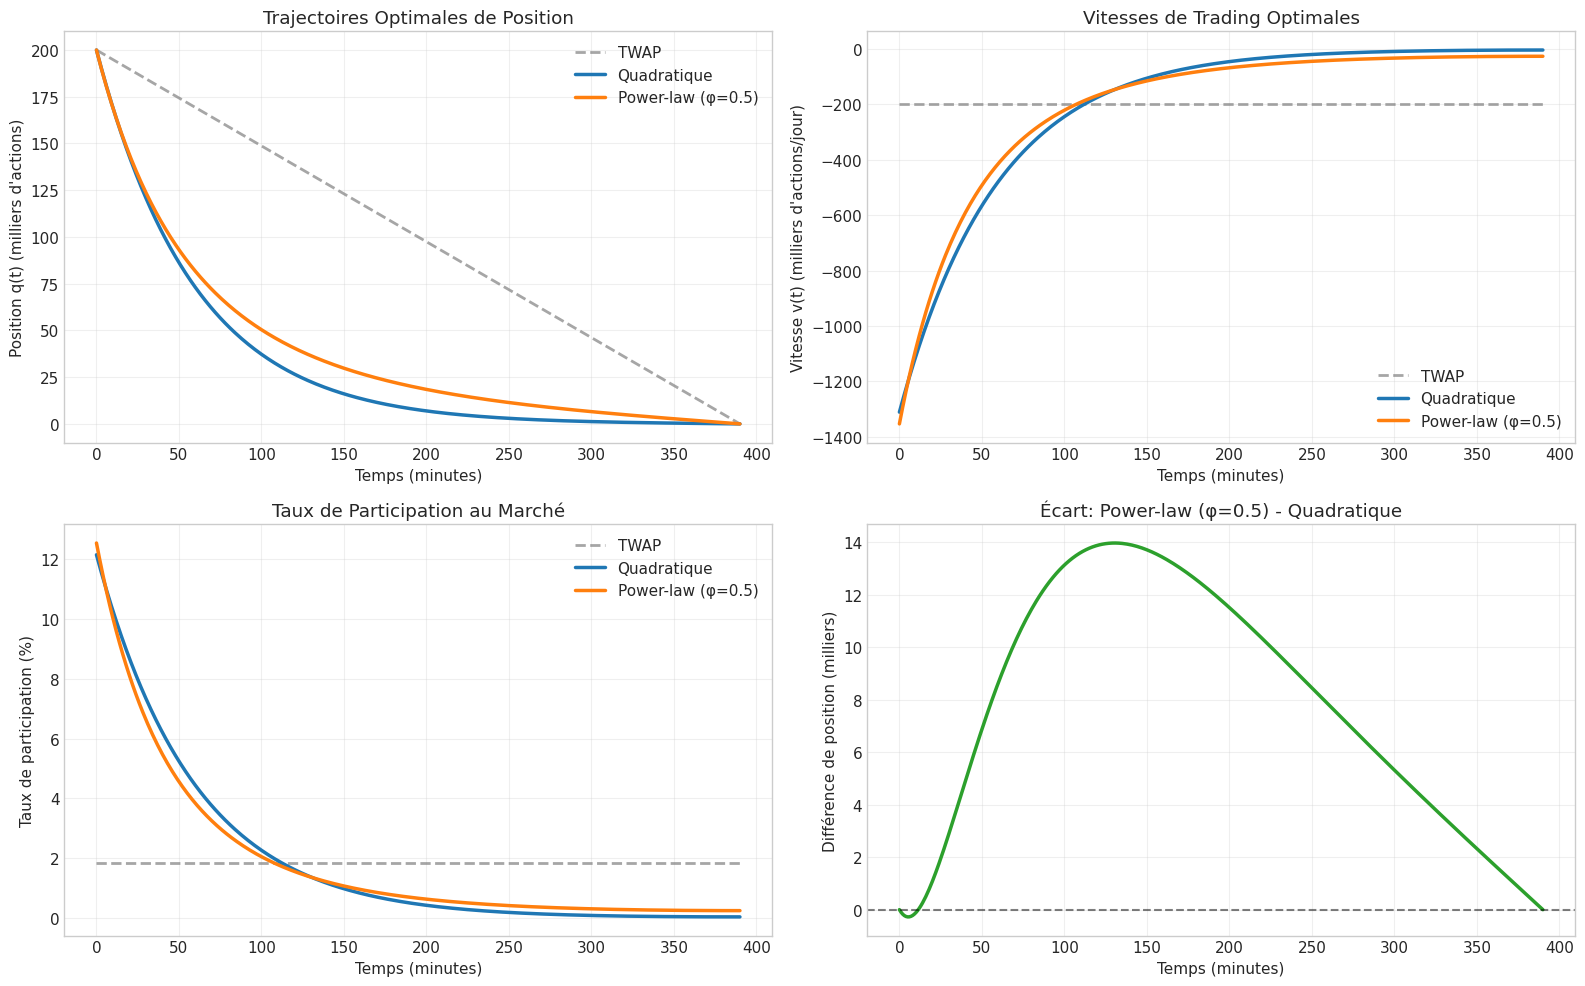

In [8]:
# Visualisation des trajectoires
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Position q(t)
ax = axes[0, 0]
ax.plot(t_twap * 390, q_twap / 1000, '--', color='gray', linewidth=2, alpha=0.7, label='TWAP')
ax.plot(t_quad * 390, q_quad / 1000, '-', color='tab:blue', linewidth=2.5, label='Quadratique')
ax.plot(t_power * 390, q_power / 1000, '-', color='tab:orange', linewidth=2.5, label=f'Power-law (φ={phi})')
ax.set_xlabel('Temps (minutes)')
ax.set_ylabel('Position q(t) (milliers d\'actions)')
ax.set_title('Trajectoires Optimales de Position')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Vitesse v(t)
ax = axes[0, 1]
ax.plot(t_twap * 390, v_twap / 1000, '--', color='gray', linewidth=2, alpha=0.7, label='TWAP')
ax.plot(t_quad * 390, v_quad / 1000, '-', color='tab:blue', linewidth=2.5, label='Quadratique')
ax.plot(t_power * 390, v_power / 1000, '-', color='tab:orange', linewidth=2.5, label=f'Power-law (φ={phi})')
ax.set_xlabel('Temps (minutes)')
ax.set_ylabel('Vitesse v(t) (milliers d\'actions/jour)')
ax.set_title('Vitesses de Trading Optimales')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Taux de participation |v|/V
ax = axes[1, 0]
ax.plot(t_twap * 390, np.abs(v_twap) / V * 100, '--', color='gray', linewidth=2, alpha=0.7, label='TWAP')
ax.plot(t_quad * 390, np.abs(v_quad) / V * 100, '-', color='tab:blue', linewidth=2.5, label='Quadratique')
ax.plot(t_power * 390, np.abs(v_power) / V * 100, '-', color='tab:orange', linewidth=2.5, label=f'Power-law (φ={phi})')
ax.set_xlabel('Temps (minutes)')
ax.set_ylabel('Taux de participation (%)')
ax.set_title('Taux de Participation au Marché')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Différence entre les modèles
ax = axes[1, 1]
diff_position = (q_power - q_quad) / 1000
ax.plot(t_power * 390, diff_position, '-', color='tab:green', linewidth=2.5)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Temps (minutes)')
ax.set_ylabel('Différence de position (milliers)')
ax.set_title(f'Écart: Power-law (φ={phi}) - Quadratique')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Analyse des Coûts

Comparaison détaillée des coûts entre les modèles.

In [9]:
# Calculer les coûts pour chaque stratégie
print("💰 Calcul des coûts...\n")

costs_quad_opt = model_quad.compute_costs(q0, T, 'optimal')
costs_quad_twap = model_quad.compute_costs(q0, T, 'twap')

costs_power_opt = model_power.compute_costs(q0, T, 'optimal')
costs_power_twap = model_power.compute_costs(q0, T, 'twap')

# Créer un DataFrame de comparaison
costs_comparison = pd.DataFrame({
    'Quadratique\nOptimal': [
        costs_quad_opt['execution_cost'] * S0,
        costs_quad_opt['permanent_impact'] * S0,
        costs_quad_opt['timing_risk'] * S0,
        costs_quad_opt['total_cost'] * S0
    ],
    'Quadratique\nTWAP': [
        costs_quad_twap['execution_cost'] * S0,
        costs_quad_twap['permanent_impact'] * S0,
        costs_quad_twap['timing_risk'] * S0,
        costs_quad_twap['total_cost'] * S0
    ],
    f'Power-law (φ={phi})\nOptimal': [
        costs_power_opt['execution_cost'] * S0,
        costs_power_opt['permanent_impact'] * S0,
        costs_power_opt['timing_risk'] * S0,
        costs_power_opt['total_cost'] * S0
    ],
    f'Power-law (φ={phi})\nTWAP': [
        costs_power_twap['execution_cost'] * S0,
        costs_power_twap['permanent_impact'] * S0,
        costs_power_twap['timing_risk'] * S0,
        costs_power_twap['total_cost'] * S0
    ]
}, index=['Exécution (€)', 'Impact permanent (€)', 'Risque timing (€)', 'Total (€)'])

print("📊 Comparaison des coûts (en euros):")
print(costs_comparison.round(2))

# Coûts en bps
notional = abs(q0) * S0
costs_bps = costs_comparison / notional * 10000
print("\n📊 Comparaison des coûts (en bps):")
print(costs_bps.round(2))

💰 Calcul des coûts...

📊 Comparaison des coûts (en euros):
                      Quadratique\nOptimal  Quadratique\nTWAP  \
Exécution (€)                         0.02               0.01   
Impact permanent (€)              50275.00           50275.00   
Risque timing (€)                248619.66         1072550.39   
Total (€)                        298894.68         1122825.40   

                      Power-law (φ=0.5)\nOptimal  Power-law (φ=0.5)\nTWAP  
Exécution (€)                          958909.09                628203.87  
Impact permanent (€)                    50275.00                 50275.00  
Risque timing (€)                      283893.19               1072550.39  
Total (€)                             1293077.27               1751029.26  

📊 Comparaison des coûts (en bps):
                      Quadratique\nOptimal  Quadratique\nTWAP  \
Exécution (€)                         0.00               0.00   
Impact permanent (€)                 12.50              12.50   
Risqu

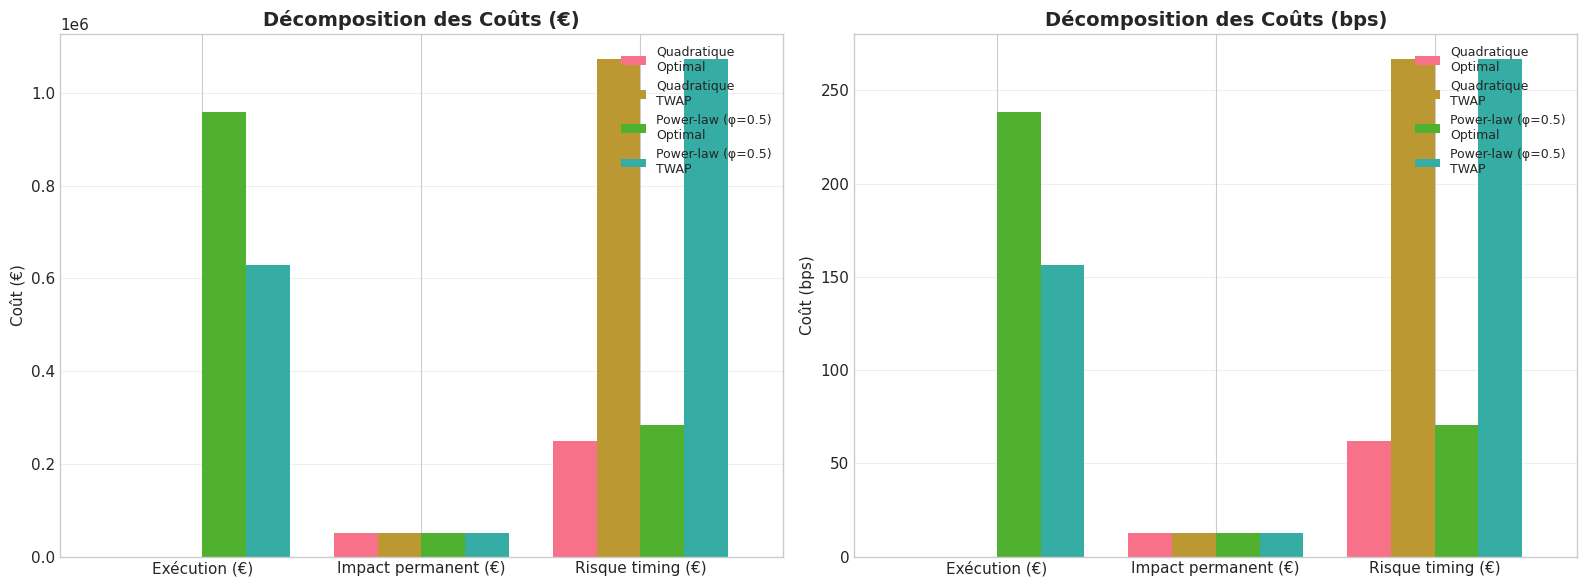


💡 Gains de l'optimisation (Optimal vs TWAP):
   Modèle quadratique: 73.38%
   Modèle power-law (φ=0.5): 26.15%

🔍 Différence entre modèles (Optimal):
   Coût total: +332.62%
   Coût d'exécution: +4158377930.96%


In [10]:
# Visualisation des coûts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Coûts en euros
ax = axes[0]
costs_comparison.iloc[:-1].plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Décomposition des Coûts (€)', fontsize=14, fontweight='bold')
ax.set_ylabel('Coût (€)')
ax.set_xlabel('')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

# 2. Coûts en bps
ax = axes[1]
costs_bps.iloc[:-1].plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Décomposition des Coûts (bps)', fontsize=14, fontweight='bold')
ax.set_ylabel('Coût (bps)')
ax.set_xlabel('')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Gains vs TWAP
print("\n💡 Gains de l'optimisation (Optimal vs TWAP):")
gain_quad = (costs_quad_twap['total_cost'] - costs_quad_opt['total_cost']) / costs_quad_twap['total_cost'] * 100
gain_power = (costs_power_twap['total_cost'] - costs_power_opt['total_cost']) / costs_power_twap['total_cost'] * 100

print(f"   Modèle quadratique: {gain_quad:.2f}%")
print(f"   Modèle power-law (φ={phi}): {gain_power:.2f}%")

# Différence entre modèles
print("\n🔍 Différence entre modèles (Optimal):")
diff_total = (costs_power_opt['total_cost'] - costs_quad_opt['total_cost']) / costs_quad_opt['total_cost'] * 100
diff_exec = (costs_power_opt['execution_cost'] - costs_quad_opt['execution_cost']) / costs_quad_opt['execution_cost'] * 100

print(f"   Coût total: {diff_total:+.2f}%")
print(f"   Coût d'exécution: {diff_exec:+.2f}%")

## 3. Analyse de Sensibilité

Impact de l'exposant φ sur la stratégie optimale.

In [11]:
# Test de différentes valeurs de φ
phi_values = [0.3, 0.4, 0.5, 0.6, 0.7, 1.0]  # 1.0 = quadratique
results_phi = []

print("🔬 Analyse de sensibilité sur φ...\n")

for phi_test in phi_values:
    print(f"   Calcul pour φ = {phi_test}...")
    
    model_test = AlmgrenChrissPowerLaw(
        lambda_risk=params['lambda_risk'],
        sigma=params['sigma'],
        k=params['k'],
        phi=phi_test,
        eta=params['eta'],
        psi=params['psi'],
        V=params['V']
    )
    
    try:
        t_test, q_test, v_test = model_test.optimal_trajectory(q0, T)
        costs_test = model_test.compute_costs(q0, T, 'optimal')
        
        results_phi.append({
            'phi': phi_test,
            'v_initial': v_test[0],
            'v_final': v_test[-1],
            'participation_initial': abs(v_test[0]) / V * 100,
            'participation_final': abs(v_test[-1]) / V * 100,
            'execution_cost': costs_test['execution_cost'] * S0,
            'total_cost': costs_test['total_cost'] * S0,
            'total_cost_bps': costs_test['total_cost'] / abs(q0) * 10000
        })
    except Exception as e:
        print(f"      ⚠️ Échec pour φ = {phi_test}: {str(e)}")

df_phi = pd.DataFrame(results_phi)

print("\n✅ Résultats:")
print(df_phi[['phi', 'participation_initial', 'participation_final', 'total_cost_bps']].round(2))

🔬 Analyse de sensibilité sur φ...

   Calcul pour φ = 0.3...
      ⚠️ Échec pour φ = 0.3: BVP solver failed: The maximum number of mesh nodes is exceeded.
   Calcul pour φ = 0.4...
   Calcul pour φ = 0.5...
   Calcul pour φ = 0.6...
   Calcul pour φ = 0.7...
   Calcul pour φ = 1.0...

✅ Résultats:
   phi  participation_initial  participation_final  total_cost_bps
0  0.4                  12.11                 0.32          392.05
1  0.5                  12.55                 0.24          321.50
2  0.6                  13.26                 0.17          270.65
3  0.7                  14.13                 0.10          233.07
4  1.0                  17.19                 0.00          164.78


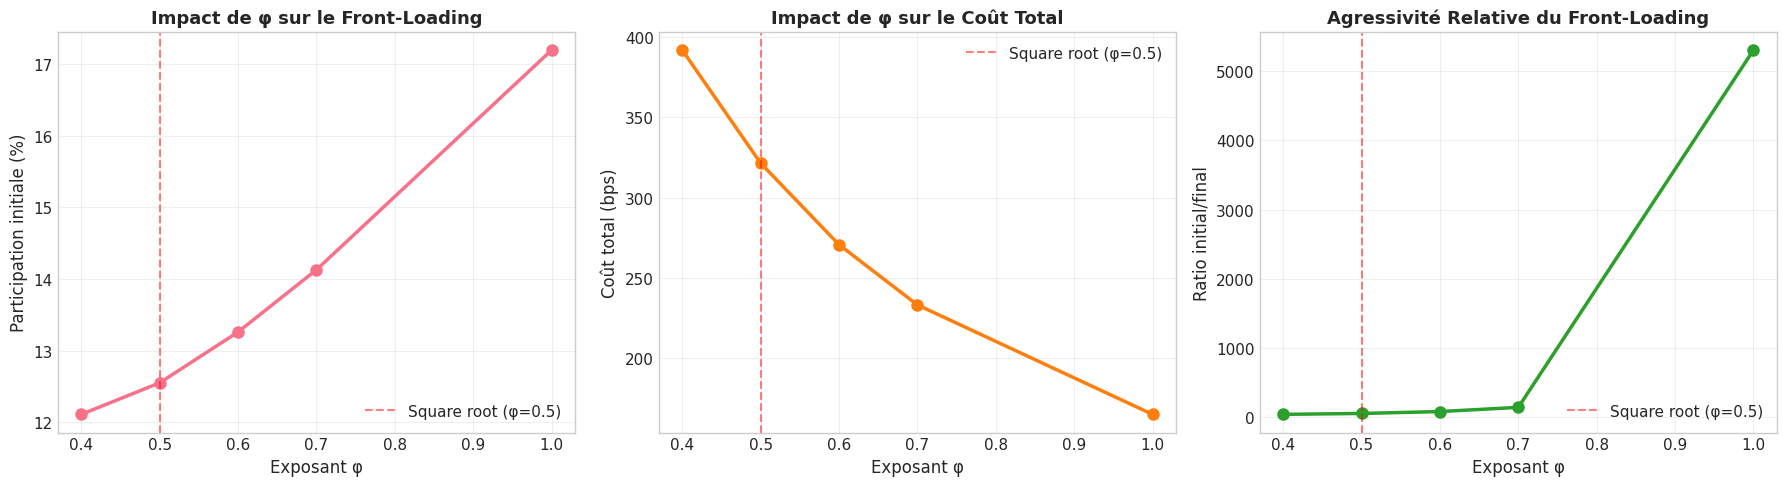


💡 Observations:
   - φ plus petit → Front-loading plus agressif (participation initiale plus élevée)
   - φ = 0.5 (square root): Compromis empiriquement validé
   - φ = 1.0 (quadratique): Modèle classique Almgren-Chriss


In [12]:
# Visualisation de la sensibilité
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Participation initiale vs φ
ax = axes[0]
ax.plot(df_phi['phi'], df_phi['participation_initial'], 'o-', linewidth=2.5, markersize=8)
ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
ax.set_xlabel('Exposant φ', fontsize=12)
ax.set_ylabel('Participation initiale (%)', fontsize=12)
ax.set_title('Impact de φ sur le Front-Loading', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Coût total vs φ
ax = axes[1]
ax.plot(df_phi['phi'], df_phi['total_cost_bps'], 'o-', linewidth=2.5, markersize=8, color='tab:orange')
ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
ax.set_xlabel('Exposant φ', fontsize=12)
ax.set_ylabel('Coût total (bps)', fontsize=12)
ax.set_title('Impact de φ sur le Coût Total', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Ratio participation initiale/finale vs φ
ax = axes[2]
ratio = df_phi['participation_initial'] / df_phi['participation_final']
ax.plot(df_phi['phi'], ratio, 'o-', linewidth=2.5, markersize=8, color='tab:green')
ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
ax.set_xlabel('Exposant φ', fontsize=12)
ax.set_ylabel('Ratio initial/final', fontsize=12)
ax.set_title('Agressivité Relative du Front-Loading', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Observations:")
print(f"   - φ plus petit → Front-loading plus agressif (participation initiale plus élevée)")
print(f"   - φ = 0.5 (square root): Compromis empiriquement validé")
print(f"   - φ = 1.0 (quadratique): Modèle classique Almgren-Chriss")

## 4. Conclusion et Recommandations

### Principales observations:

1. **Modèle power-law vs quadratique**:
   - Le modèle power-law (φ=0.5) reflète mieux la concavité empirique de l'impact de marché
   - Différences significatives dans le front-loading et les coûts d'exécution

2. **Calibration empirique**:
   - φ = 0.5 (square root): Large consensus dans la littérature (Almgren+ 2005, Kyle & Obizhaeva 2016)
   - Impact permanent linéaire (k): Seul choix sans arbitrage (Huberman & Stanzl 2004)

3. **Implications pratiques**:
   - Front-loading plus marqué avec coûts sous-quadratiques
   - Importance de la calibration empirique pour des prédictions réalistes
   - Trade-off entre précision du modèle et complexité de résolution

### Recommandations:

1. **Pour la recherche**:
   - Utiliser φ ∈ [0.4, 0.6] basé sur la littérature empirique
   - Calibrer sur données réelles d'exécution
   - Tester sensibilité aux paramètres

2. **Pour la production**:
   - Commencer avec φ = 0.5 (square root law)
   - Ajuster selon les caractéristiques du marché
   - Valider sur données out-of-sample

3. **Extensions futures**:
   - Volume intraday non constant (courbe en U)
   - Impact résilient (décroissance temporelle)
   - Multi-actifs avec corrélations

In [13]:
# Sauvegarde des résultats
results_dict = {
    'parameters': params,
    'literature_references': {
        'phi_range': [0.4, 0.7],
        'phi_recommended': 0.5,
        'sources': [
            'Almgren et al. (2005) - Direct Estimation of Equity Market Impact',
            'Kyle & Obizhaeva (2016) - Market Microstructure Invariance',
            'Bacry et al. (2015) - Market Impact: Empirical Evidence',
            'Guéant (2016) - Financial Mathematics of Market Liquidity'
        ]
    },
    'quadratic_model': {
        'trajectory': {
            't': t_quad.tolist(),
            'q': q_quad.tolist(),
            'v': v_quad.tolist()
        },
        'costs': costs_quad_opt
    },
    'power_law_model': {
        'trajectory': {
            't': t_power.tolist(),
            'q': q_power.tolist(),
            'v': v_power.tolist()
        },
        'costs': costs_power_opt
    },
    'sensitivity_phi': df_phi.to_dict('records')
}

with open('results/almgren_chriss_power_law_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2, default=float)

print("✅ Résultats sauvegardés dans 'results/almgren_chriss_power_law_results.json'")

✅ Résultats sauvegardés dans 'results/almgren_chriss_power_law_results.json'
